In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))
font = {# 'family' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [2]:
import pandas as pd
import numpy as np
import os
import astropy.units as u
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Read in files and fix formatting

In [3]:
def file2df(file):
    with open(file, 'r') as ff:
        line = ff.readline()
        cols = line.strip('#').split()
    return pd.read_csv(file, comment='#', delim_whitespace=True, names=cols)


obs = file2df('../LSSTsimWDobs60.dat')
truth = file2df('../LSSTsimWDtruth60.dat')

obs.reset_index(inplace=True)
obs.columns = ['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs', 'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs', 'muDecObs', 'muErr']

In [4]:
obs.head()

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,zObs,zErr,yObs,yErr,piObs,piErr,muRAObs,muDecObs,muErr
0,183.487,-1.36738,22.462,0.009,22.274,0.005,22.572,0.005,22.842,0.007,23.127,0.013,23.408,0.048,1.02,0.91,-1.60,-6.76,0.32
1,183.261,-1.25781,25.574,0.106,25.173,0.024,25.251,0.022,25.338,0.046,25.570,0.112,25.723,0.400,1.17,8.95,-3.19,-9.73,3.09
2,183.038,-1.32316,24.688,0.050,24.341,0.012,24.302,0.010,24.356,0.019,24.442,0.042,24.845,0.140,2.90,3.84,1.84,0.17,1.32
3,183.127,-1.13602,23.267,0.015,22.912,0.006,22.835,0.006,22.867,0.007,22.966,0.012,23.066,0.035,0.24,1.11,-12.58,3.17,0.38
4,183.339,-1.39733,23.504,0.018,23.093,0.006,22.963,0.006,22.957,0.007,23.034,0.012,23.088,0.036,-0.23,1.22,-8.69,-10.08,0.42


In [5]:
truth.head()

,ra,dec,u,g,r,i,z,y,Mr,logg,vR,vPhi,vZ,T,P
0,183.487,-1.36738,22.454,22.269,22.566,22.846,23.133,23.420,11.338,8.0,-50.89,-134.57,40.51,1,1
1,183.261,-1.25781,25.549,25.183,25.235,25.364,25.546,25.729,12.346,8.0,-51.56,-53.51,-3.59,1,1
2,183.038,-1.32316,24.718,24.354,24.301,24.356,24.471,24.587,12.867,8.0,-47.11,-170.19,94.17,1,1
3,183.127,-1.13602,23.288,22.913,22.834,22.871,22.972,23.073,12.989,8.0,29.71,-196.22,33.81,1,1
4,183.339,-1.39733,23.517,23.099,22.959,22.960,23.030,23.100,13.249,8.0,-4.74,-187.17,-37.27,1,1


# Problem A

## Define "Gold Sample" and Find Distance
Define a gold parallax sample" by requiring a signal-to-noise ratio of at least 10 for the trigonometric parallax measurement (i.e., piObs/piErr > 10). 

Compute the distance and distance modulus from the parallax measurement (D/kpc=1 milliarcsec/piObs) and compare it to the distance modulus determined from r and Mr listed in the \truth" file. 

In [6]:
# Calculate SNR and define a new dataframe with only gold sample WDs
obs['SNR'] = obs['piObs'] / obs['piErr']
gold_mask = np.abs(obs['SNR']) > 10
obs_gold = obs[gold_mask]

# Calculate the DM of these WDs
obs_gold['D(kpc)'] = 1 / obs_gold['piObs']
obs_gold['DM'] = 5 * np.log10(obs_gold['D(kpc)'] * 1000) - 5

# Calculate the truth DM values
truth['DM'] = truth['r'] - truth['Mr']

# Select the rows corresponding to the gold sample
truth_gold = truth[gold_mask]

### Compare observed and truth distances

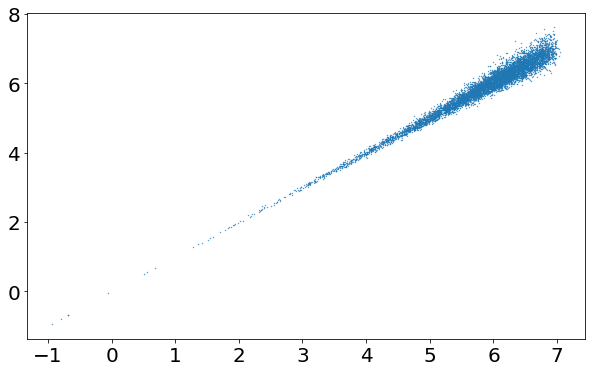

In [7]:
# Plot obs DM vs truth DM for gold sample
plt.scatter(obs_gold['DM'], truth_gold['DM'], marker='.', s=.5)
plt.show()

The correlation between the DM calculated from the observed data is strongly correlated with the true value.

In [8]:
# spot check on # in gold sample:
len(obs_gold)

7156

## Examine distribution of distance modulus

Plot the distribution of the distance modulus difference and compute its median and root-mean-square scatter (hint: beware of outliers and clip at 3sig!). 
- Are they interestingly" small? Is the distribution deviating from a gaussian? 
- Would you expect it to? Why?

In [9]:
diffs_gold = obs_gold['DM'] - truth_gold['DM']
mask_sig3 = ~(diffs_gold > 3 * np.abs(diffs_gold.std(ddof=0)))
diffs_gold = diffs_gold.loc[mask_sig3] # clip past 3 sig

#### Find mean difference

In [10]:
mean = diffs_gold.mean()
mean

-0.03512236317840359

#### Find median difference

In [11]:
med = diffs_gold.median()
med

-0.02356678321427985

#### Find root mean square error of difference

In [12]:
rms = diffs_gold.std(ddof=0)
rms

0.1568491088057002

### Use median and IQR to estimate stdev (sigmaG)

In [13]:
sigmaG = .7413 * (diffs_gold.quantile(.75) - diffs_gold.quantile(.25))
sigmaG

0.13767560340496635

These summary statistics show that there is only a very slight bias in the observed DM vs the truth value. The RMSE in DM, ~.157, will propagate to the same error in absolute magnitude, which is actually pretty good. Most of this error is likely due to uncertainty in the parallax measurement (corresponds to ~7% uncertainty in the parallax).

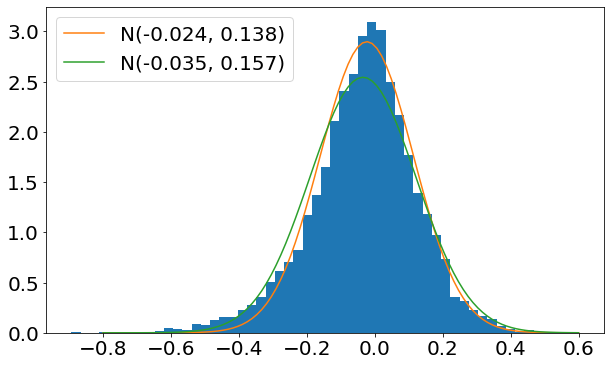

In [14]:
from scipy.stats import norm
plt.hist(diffs_gold, bins=50, density=True)
plt.plot(np.linspace(-.8, .6, 100), norm(med, sigmaG).pdf(np.linspace(-.8, .6, 100)), label=f"N({med:.3f}, {sigmaG:.3f})")
plt.plot(np.linspace(-.8, .6, 100), norm(mean, rms).pdf(np.linspace(-.8, .6, 100)), label=f"N({mean:.3f}, {rms:.3f})")
plt.legend()
plt.show()

The error look fairly normal at a glance. The using the median and IQR to estimate mean and standard devation seems to describe the bulk of the distribution very well. The negative value of the mean shows a slight bias that exceeds the standard error of the mean (~.002 vs .02), meaning that observations systematically underestimate distances. Additionally, we see that the tails are wider than expected for both gaussian fits--the reason for the N(mean, RMSE) fit being wider is partly to account for these large tails. This indicates that the error may be nongaussian and potentially indicates a different distribution (at least one paper I found online shows evidence for a lorentzian/cauchy distribution for the differences in Gaia DR1 parallax measurements and earlier parallax measurements: https://core.ac.uk/download/pdf/216252519.pdf). For an in depth analysis, we might investigate what properties in the dataset correlate with larger than expected 

In [15]:
rms / np.sqrt(len(diffs_gold))

0.0018550661761765961

### Calculate number of stars expected in full sample
How many white dwarfs would you expect in a \gold parallax sample" from the full LSST survey area of 20,000 deg2 (hint: simply scale by the area because the distance cutoff is smaller than the thin disk scaleheight)? 



Integrating the surface area of a sphere:
\begin{equation}
\int_{0}^{2\pi}\int_{\frac{5\pi}{6}}^{\pi} sin(b) db dl
\end{equation}
We get $2\pi(1-\frac{\sqrt{3}}{2}) \approx 0.8418 Sr$, or roughly $2763 deg^2$

In [16]:
# spot check with monte carlo
def run_mc(obs, n=100000, dec_bounds=None):
    if dec_bounds is None:
        bounds = {round(ra,1): obs.loc[(obs['ra'] < round(ra, 1) + .1) & (obs['ra'] > round(ra, 1)-.1), 'dec'].quantile([0,1]) for ra in np.linspace(158, 228, 701)}
        dec_bounds = pd.DataFrame(bounds).T.dropna()
        dec_bounds.columns = ['dec_min', 'dec_max']

    ra_min, ra_max = obs['ra'].quantile([0,1])
    dec_min, dec_max = obs['dec'].quantile([0,1])
    
    ras = np.random.choice(np.linspace(0, 359, 360), n)
    decs_weights = np.cos(np.linspace(-np.pi/2, np.pi/2, 91))/sum(np.cos(np.linspace(-np.pi/2, np.pi/2, 91)))
    decs = np.random.choice(np.linspace(-90, 90, 91),n,  p=decs_weights)
    
    mask = (ras > ra_min) & (ras < ra_max) & (decs > dec_min) & (decs < dec_max)
    num = 0
    for ra, dec in zip(ras[mask], decs[mask]):
        # sub = obs.loc[(obs['ra'] < ra + 1) & (obs['ra'] > ra-1)]
        dec_min, dec_max = dec_bounds.loc[round(ra,1)]
        if (dec < dec_max) and (dec > dec_min):
            num+=1
    return num / n

# coords.append((decs, ras))

In [17]:
# monte carlo agrees prety well
run_mc(obs, n=1000000) * 41252

2767.5141759999997

### Scale number of gold sample by area

In [18]:
20000/2763 * len(obs_gold)

51798.769453492576

We expect to see roughly 51800 white dwarfs in the full LSST sample meeting our gold standard of SNR > 10.

## Gold sample color color plot
Plot the (g-r) vs. (u-g) color-color diagram (using observed photometry) for this sample. Does it look crisper than the SDSS distribution 1https://ls.st/lop
2 shown in the bottom left corner of fig. 23 in Ivezic et al. (2007, AJ, 134, 973)?

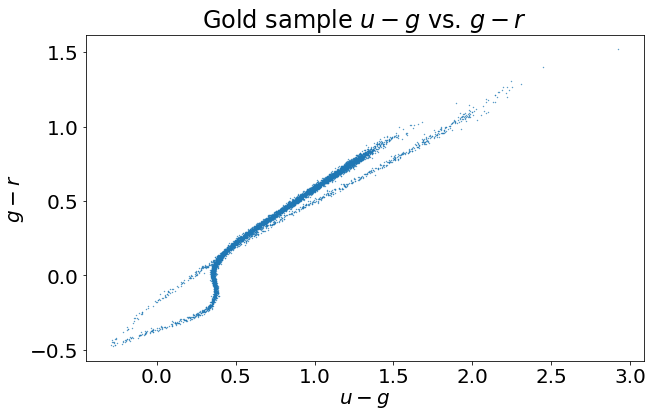

In [19]:
plt.scatter( obs_gold['uObs'] - obs_gold['gObs'], obs_gold['gObs'] - obs_gold['rObs'], marker='.', s=.5)
plt.ylabel(r'$g-r$')
plt.xlabel(r'$u-g$')
plt.title(r'Gold sample $u-g$ vs. $g-r$')
plt.show()

Compared to fig 23 in Ivezic, 2007, this lot looks much crisper, particularly for higher g-r. The different tracks for hydrogen and helium white dwarfs are also visible
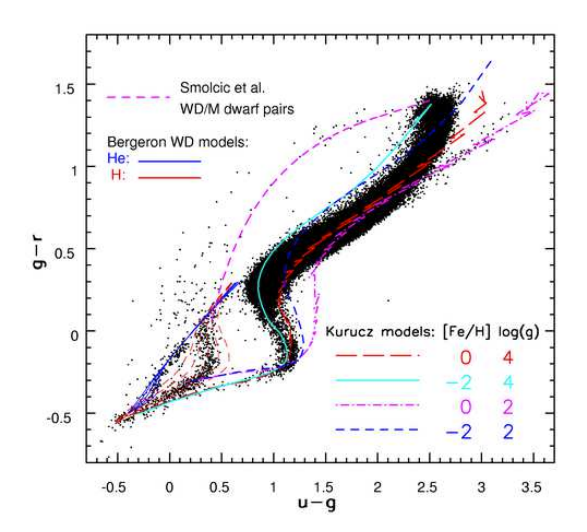

# Question B

## Estimate absolute magnitude from gObs-rObs
Using the “gold parallax sample” from A, estimate the absolute r band magnitude as Mobs = rObs − DMobs, with the observed distance modulus, DMobs, determined using the “measured” trigonometric parallax, piObs. Plot Mobs vs. (gObs−rObs) color for stars with T=1 (i.e., hydrogen white WDs; while this is a shortcut based on model input, it is possible to photometrically distinguish hydrogen from helium WDs by considering their four-dimensional color loci; however, this is beyond the scope of this project and hence this shortcut). 

### Select only hydrogen white dwarfs, plot g-r vs Mr

In [20]:
obs_gold['MrObs'] = obs_gold['rObs'] - obs_gold['DM']
hydrogen_WDs = obs_gold.loc[truth_gold['T'] == 1]

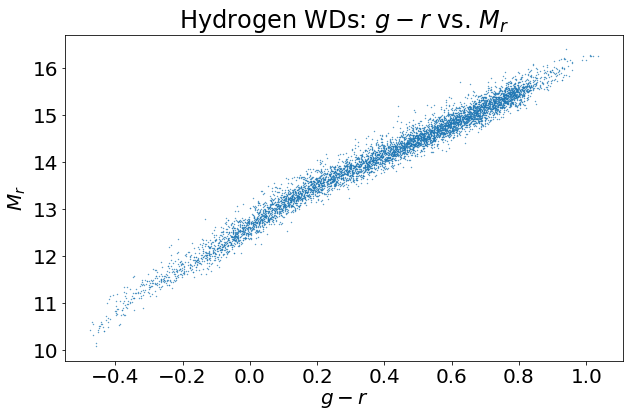

In [21]:
plt.scatter(hydrogen_WDs['gObs'] - hydrogen_WDs['rObs'], hydrogen_WDs['MrObs'], marker='.', s=.5)
plt.xlabel(r'$g-r$')
plt.ylabel(r'$M_r$')
plt.title(r'Hydrogen WDs: $g-r$ vs. $M_r$')
plt.show()

### Fit function to binned g-r vs Mr

Fit a low-order polynomial to derive a photometric parallax relation, Mr(g−r) (hint: you may want to first compute the median Mr in about 0.1 mag wide bins of the g − r color, and then fit a polynomial to these median values vs. g −r bin value). How did you choose the order of your polynomial fit? In what range of Mr and (g − r) is your relation valid?

In [22]:
# Calculate g-r
hydrogen_WDs['g-r'] = hydrogen_WDs['gObs'] - hydrogen_WDs['rObs']


In [23]:
# Make bins of size ~.1 mag in g-r, find median Mr per bin

bins = np.arange(hydrogen_WDs['g-r'].min(), hydrogen_WDs['g-r'].max(), .1)
centers = (bins[1:] + bins[:-1]) / 2

hydrogen_WDs['bin'] = pd.cut(hydrogen_WDs['g-r'], bins, labels=centers).astype(float)
bin_meds = hydrogen_WDs.groupby('bin')['MrObs'].apply(np.median)

Calculate summary statistics per bin

In [24]:
bin_meds = hydrogen_WDs.groupby('bin')['MrObs'].apply(np.median)
bin_stds = hydrogen_WDs.groupby('bin')['MrObs'].apply(np.std)  # not necessary
bin_counts = hydrogen_WDs.groupby('bin')['MrObs'].agg('count')  # not necessary

##### Optional
Use standard error of the mean as uncertainy in later calculation of reduced $\chi^2$

In [25]:
bin_sterr = bin_stds / np.sqrt(bin_counts)

### Fit polynomials from n=1 to n=4
Also calculate reduced-$\chi^2$

In [26]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare

def lin(x, a, b):
    return a * x + b

def quad(x, a, b, c):
    return a * x ** 2 + b * x + c

def cubic(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x  + d

def quar(x, a, b, c, d, e):
    return a * x ** 4 + b * x ** 3 + c * x **2  + d * x + e

def quin(x, a, b, c, d, e, f):
    return a * x ** 5 + b * x ** 4 + c * x ** 3  + d * x **2 + e * x + f

def red_chi_sq(obs, model, err, dof):
    return sum((obs - model) ** 2 / err ** 2) / (len(obs) - 1 - dof)

def calculate_gauss_BIC(obs, model, err, n_params):
    n_data = len(obs)
    
    # calculate log likelihood assuming normal error
    LL = -0.5 * sum((np.log(2 * np.pi * err ** 2) + ((obs - model) ** 2 / err ** 2)))
    BIC = n_params * np.log(n_data) - 2 * LL
    return BIC



popt_lin, pcov_lin = curve_fit(lin, bin_meds.index, bin_meds)
popt_quad, pcov_quad = curve_fit(quad, bin_meds.index, bin_meds)
popt_cubic, pcov_cubic = curve_fit(cubic, bin_meds.index, bin_meds)
popt_quar, pcov_quar = curve_fit(quar, bin_meds.index, bin_meds)
popt_quin, pcov_quin = curve_fit(quin, bin_meds.index, bin_meds)

lin_chi2 = red_chi_sq(bin_meds, lin(bin_meds.index, *popt_lin), bin_sterr, 2)
quad_chi2 = red_chi_sq(bin_meds, quad(bin_meds.index, *popt_quad), bin_sterr, 3)
cubic_chi2 = red_chi_sq(bin_meds, cubic(bin_meds.index, *popt_cubic), bin_sterr, 4)
quar_chi2 = red_chi_sq(bin_meds, quar(bin_meds.index, *popt_quar), bin_sterr, 5)
quin_chi2 = red_chi_sq(bin_meds, quin(bin_meds.index, *popt_quin), bin_sterr, 6)

lin_BIC = calculate_gauss_BIC(bin_meds, lin(bin_meds.index, *popt_lin), bin_sterr, 3)
quad_BIC = calculate_gauss_BIC(bin_meds, quad(bin_meds.index, *popt_quad), bin_sterr, 4)
cubic_BIC = calculate_gauss_BIC(bin_meds, cubic(bin_meds.index, *popt_cubic), bin_sterr, 5)
quar_BIC = calculate_gauss_BIC(bin_meds, quar(bin_meds.index, *popt_quar), bin_sterr, 6)
quin_BIC = calculate_gauss_BIC(bin_meds, quin(bin_meds.index, *popt_quin), bin_sterr, 7)



### Plot fit and residuals

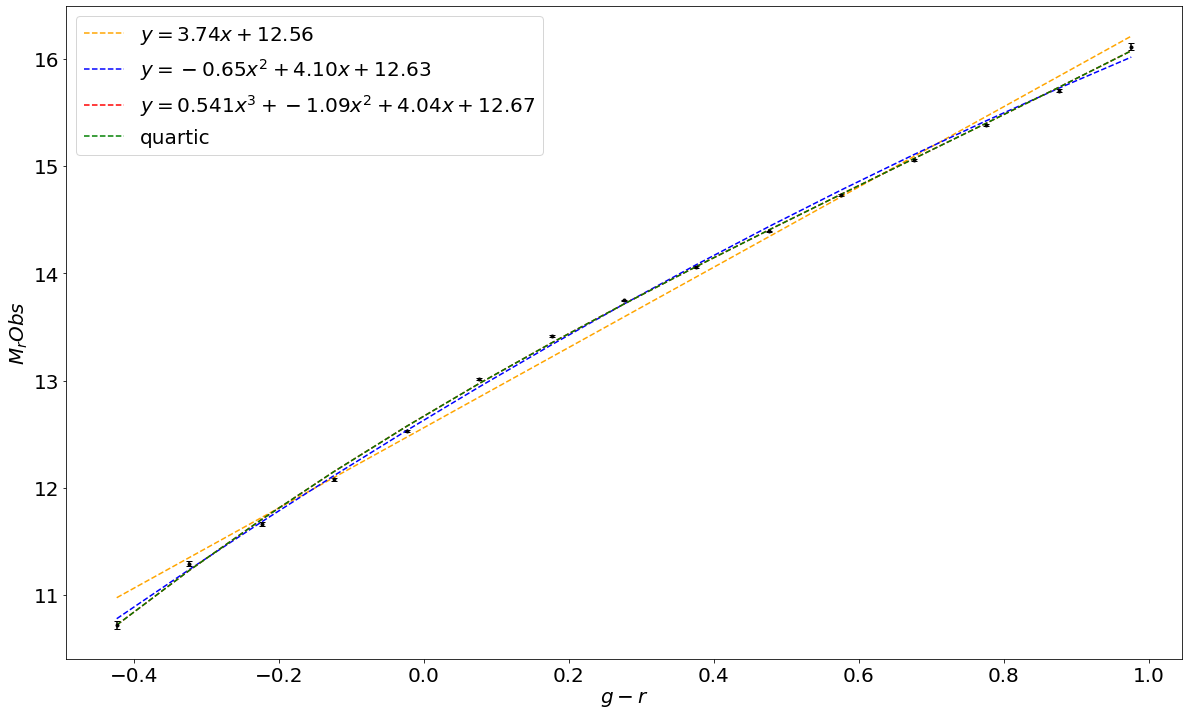

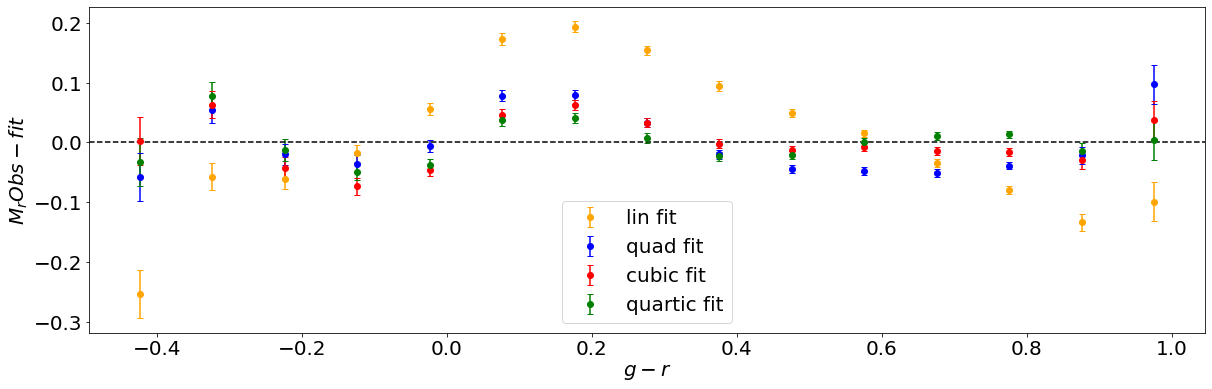

In [27]:
plt.figure(figsize=(20,12))
plt.errorbar(bin_meds.index, bin_meds.values, yerr=bin_sterr, fmt='.', color='k', capsize=3, )
plt.plot(bin_meds.index, lin(bin_meds.index, *popt_lin), label=r'$y = {:.2f}x + {:.2f}$'.format(*popt_lin), color='orange', linestyle='--')
plt.plot(bin_meds.index, quad(bin_meds.index, *popt_quad), label=r'$y = {:.2f}x^2 + {:.2f}x + {:.2f}$'.format(*popt_quad), color='b', linestyle='--')
plt.plot(bin_meds.index, cubic(bin_meds.index, *popt_cubic), label=r'$y = {:.3f}x^3 + {:.2f}x^2 + {:.2f}x + {:.2f}$'.format(*popt_cubic), color='r', linestyle='--')
plt.plot(bin_meds.index, cubic(bin_meds.index, *popt_cubic), label='quartic', color='g', linestyle='--')
plt.legend()
plt.xlabel(r'$g-r$')
plt.ylabel(r'$M_rObs$')
plt.show()

def resid(model, obs=bin_meds.values):
    return obs - model

plt.figure(figsize=(20,6))
# plt.errorbar(bin_meds.index, bin_meds.values, yerr=bin_sterr.values, fmt='.', color='k', capsize=3, )
plt.errorbar(bin_meds.index, resid(lin(bin_meds.index, *popt_lin)), yerr=bin_sterr, label='lin fit', color='orange', capsize=3, fmt='o')
plt.errorbar(bin_meds.index, resid(quad(bin_meds.index, *popt_quad)), yerr=bin_sterr, label='quad fit', color='b', capsize=3, fmt='o')
plt.errorbar(bin_meds.index, resid(cubic(bin_meds.index, *popt_cubic)), yerr=bin_sterr, label='cubic fit', color='r', capsize=3, fmt='o')
plt.errorbar(bin_meds.index, resid(quar(bin_meds.index, *popt_quar)), yerr=bin_sterr, label='quartic fit', color='g', capsize=3, fmt='o')
# plt.errorbar(bin_meds.index, resid(quin(bin_meds.index, *popt_quin)), yerr=bin_sterr, label='quintic fit', color='brown', capsize=3, fmt='o')
plt.axhline(0, color='k', ls='--')
plt.legend()
plt.xlabel(r'$g-r$')
plt.ylabel(r'$M_rObs - fit$')
plt.show()

### Compare reduced $\chi^2$

In [28]:
lin_chi2

150.21242094850916

In [29]:
quad_chi2

36.31947130284686

In [30]:
cubic_chi2

17.407909475752657

In [31]:
quar_chi2

11.686492476818918

In [32]:
quin_chi2

14.648140688007881

### Compare BIC

In [33]:
lin_BIC

1704.6603078062833

In [34]:
quad_BIC

304.3334909565907

In [35]:
cubic_BIC

81.6064515839041

In [36]:
quar_BIC

15.413839318850039

In [37]:
quin_BIC

30.128582732645057

Note that both metrics for model selection agree that the quartic fit is the optimal model for this data. However we do note that neither the reduced $\chi^2$ nor the BIC show our model to be a great fit. This is backed up by the residual plot, which displays a clear pattern. Thus in the future, we may want to consider models other than polynomials

Additionally, our dataset of points to fit, after binning, has size ~15. We may wish to decrease the size of the bins (while increasing the stderr for each bin) to attempt additional fits. The BIC also is a more useful statistic when n, the size of the dataset, is much greater than k, the number of model parameters.

### Get Mr bounds this fit is valid on
We should trust our fit on the range of g-r that our data is fitted over:

In [38]:
print(f"Valid from {hydrogen_WDs['g-r'].min():.2f}  < g-r < to {hydrogen_WDs['g-r'].max():.2f}")
print(f"and from {quar(hydrogen_WDs['g-r'].min(), *popt_quar):.2f} < M_r <  {quar(hydrogen_WDs['g-r'].max(), *popt_quar):.2f}")

Valid from -0.47  < g-r < to 1.03
and from 10.53 < M_r <  16.36


Looking at the residuals, it looks like our model does not deviate significantly from the data near the bounds of g-r. Thus we _might_ be able to safely extrapolate a bit in each direction

# Question C
Define a “gold proper motion sample” by requiring rObs < 24.5. What fraction of this sample has the observed proper motion measured witha signal-to-noise ratio (to compute SNR: add the two proper motion components in quadrature and divide by the listed proper motion error) of at least 3? 

### Define gold proper motion sample
Also look % with SNR > 3

In [39]:
ps_mask = obs['rObs'] < 24.5
ps_gold = obs[ps_mask]
ps_gold['mu'] = np.sqrt(ps_gold['muRAObs'] ** 2 + ps_gold['muDecObs'] ** 2)
print('Proportion of gold proper motion sample with SNR > 3: {:.3f}'.format((ps_gold['mu'] / ps_gold['muErr'] > 3).mean()))

Proportion of gold proper motion sample with SNR > 3: 0.975


drop SNR < 3

In [40]:
ps_gold = ps_gold.query('mu/muErr > 3')
ps_mask = [x in ps_gold.index for x in obs.index]

In [41]:
# Spot check number of values
sum(ps_mask)

178244

### Apply photometric relation from B to get Mr
Apply your photometric parallax relation from B to estimate Mr and distance (using Mr and rObs). Use this distance to compute tangential velocity, vtan (of course, you also need the observed proper motion; be careful about units!). 

In [42]:
ps_gold['g-r'] = ps_gold['gObs'] - ps_gold['rObs']

# backticks on query to treat quantity as string
# cut our sample to the range over which our Photometric relation holds
ps_gold = ps_gold.query("(`g-r` > -0.4) & (`g-r` < 1.0)")
ps_mask = [x in ps_gold.index for x in obs.index]

ps_gold['Phot_Mr'] = quar(ps_gold['g-r'], *popt_quar)
ps_gold['D(pc)'] = 10 ** ((ps_gold['rObs'] - ps_gold['Phot_Mr']) / 5 + 1)

In [43]:
# spot check on ps_gold
ps_gold

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,...,piObs,piErr,muRAObs,muDecObs,muErr,SNR,mu,g-r,Phot_Mr,D(pc)
0,183.487,-1.36738,22.462,0.009,22.274,0.005,22.572,0.005,22.842,0.007,...,1.02,0.91,-1.60,-6.76,0.32,1.120879,6.946769,-0.298,11.335388,1767.348933
3,183.127,-1.13602,23.267,0.015,22.912,0.006,22.835,0.006,22.867,0.007,...,0.24,1.11,-12.58,3.17,0.38,0.216216,12.973253,0.077,12.985650,932.975029
4,183.339,-1.39733,23.504,0.018,23.093,0.006,22.963,0.006,22.957,0.007,...,-0.23,1.22,-8.69,-10.08,0.42,-0.188525,13.308738,0.130,13.196236,898.158025
5,183.624,-1.42716,24.233,0.031,23.762,0.008,23.599,0.007,23.588,0.010,...,2.33,2.07,-7.61,3.03,0.72,1.125604,8.191032,0.163,13.323885,1135.070922
11,183.776,-1.55913,25.296,0.084,24.697,0.016,24.364,0.011,24.274,0.018,...,1.16,4.09,-2.48,10.55,1.41,0.283619,10.837569,0.333,13.940513,1215.338802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905971,220.372,48.20000,24.935,0.066,24.602,0.015,24.404,0.011,24.421,0.020,...,0.70,4.26,-19.55,-14.13,1.47,0.164319,24.121762,0.198,13.456361,1547.133340
906097,216.576,51.05020,24.266,0.032,23.869,0.009,23.764,0.008,23.796,0.012,...,3.66,2.39,-30.51,14.66,0.83,1.531381,33.849309,0.105,13.097756,1359.092004
906138,216.191,51.30080,24.695,0.048,24.313,0.012,24.354,0.011,24.496,0.021,...,4.48,4.06,-5.09,-13.91,1.40,1.103448,14.812029,-0.041,12.493070,2356.058636
906143,216.052,51.50110,24.797,0.054,24.437,0.013,24.467,0.012,24.543,0.022,...,5.32,4.39,-10.91,-9.49,1.52,1.211845,14.459882,-0.030,12.540292,2428.519093


### Calculate DMs using Photometric Mr

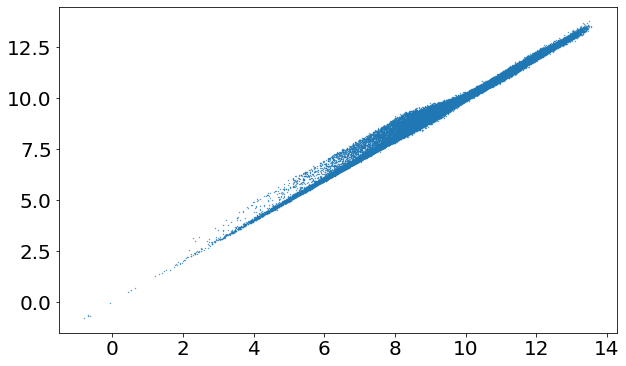

In [44]:
ps_gold['DM'] = ps_gold['rObs'] - ps_gold['Phot_Mr']

# Spot check with truth file
plt.scatter(ps_gold['rObs'] - ps_gold['Phot_Mr'], truth.loc[ps_mask, 'DM'], s=.5, marker='.')
plt.show()

## Look at different cutoffs for determining Disk v Halo stars by $v_{tan}$

Define a candidate disk sample as stars with vtan < vcutoff tan , and a candidate halo sample as stars with vtan > vcutoff tan . Using P from the truth file, plot the completeness and contamination for disk and halo samples as a function of v cutoff tan for 0 < vcutoff tan < 500 km/s (in steps of, say, 20 km/s). 

The completeness is defined as the number of (disk, halo) objects in the selected subsample divided by the total number of such objects, and contamination is the number of objects of the “wrong” type in the selected subsample divided by the total number in that subsample.

### Calculate $v_{tan}$

In [45]:
yr2s = 3.154e7
pc2km = 3.086e13
rad_p_s = (ps_gold['mu'] / 1000 / 3600) * (np.pi / 180) / yr2s
ps_gold['vTan'] =  rad_p_s * ps_gold['D(pc)'] * pc2km

In [46]:
# spot check v_tan
ps_gold['vTan']

0          58.239047
3          57.415350
4          56.702045
5          44.103261
11         62.479614
             ...    
905971    177.029594
906097    218.226637
906138    165.542590
906143    166.577133
906157    172.582658
Name: vTan, Length: 175038, dtype: float64

In [47]:
ps_gold.to_csv('../ps_gold.csv', index=False)

### Calculate completeness and contamination

In [48]:
def get_comp_cont(sample_index, truth_df, seg):
    n_seg = sum(truth_df['P'] == seg)
    sample_len = len(sample_index)
    
    truth_values = truth_df.loc[sample_index, 'P']
    right = sum(truth_values == seg)
    wrong = sum(truth_values != seg)
    return right / n_seg, wrong / sample_len


disk_results = []
halo_results = []
for v_cutoff in np.linspace(20, 500, 25):
    disk_mask = ps_gold['vTan'] < v_cutoff
    halo_mask = ps_gold['vTan'] > v_cutoff
    
    disk_comp, disk_cont = get_comp_cont(ps_gold.loc[disk_mask].index, truth[ps_mask], 1)
    halo_comp, halo_cont = get_comp_cont(ps_gold.loc[halo_mask].index, truth[ps_mask], 2)
    disk_results.append((v_cutoff, disk_comp, disk_cont))
    halo_results.append((v_cutoff, halo_comp, halo_cont))


In [49]:
disk_df = pd.DataFrame(disk_results, columns=['vTan', 'completeness', 'contamination'])
halo_df = pd.DataFrame(halo_results, columns=['vTan', 'completeness', 'contamination'])
disk_df.set_index('vTan', inplace=True)
halo_df.set_index('vTan', inplace=True)

### Plot v_cutoff vs completeness, contamination for disk and halo
Note that there are many more disk objects than halo objects

<AxesSubplot:title={'center':'Halo'}, xlabel='vTan'>

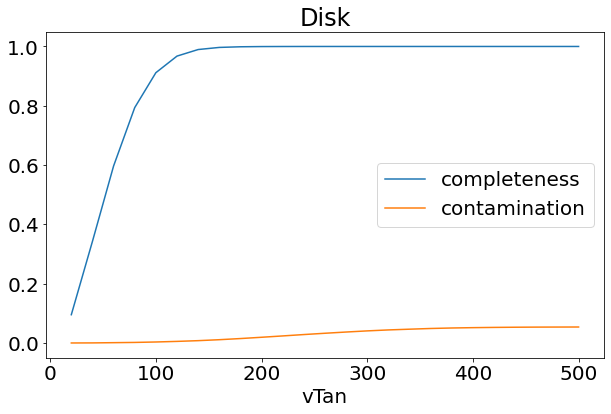

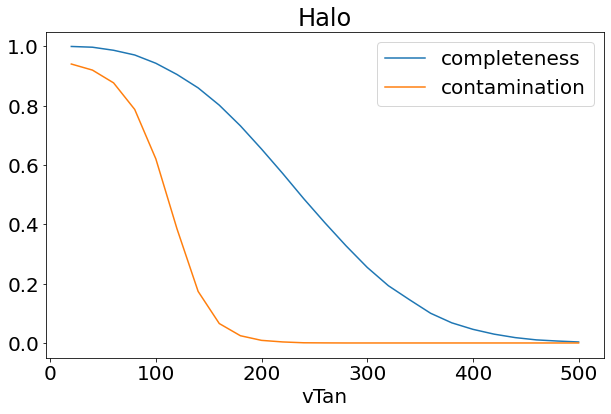

In [50]:
disk_df.plot(title='Disk')
halo_df.plot(title='Halo')


# Question D
Using the “gold proper motion sample” from C, define a candidate disk sample by vtan < 150 km/s, and a candidate halo sample by vtan > 200 km/s. Using your results from C, estimate the completeness and contamination for each subsample. 

## Find confusion matrix of our cutoffs

In [51]:
v_cutoff = 150 #km/s
disk_mask = ps_gold['vTan'] < v_cutoff
halo_mask = ps_gold['vTan'] > 200 

disk_comp, disk_cont = get_comp_cont(ps_gold.loc[disk_mask].index, truth[ps_mask], 1)
halo_comp, halo_cont = get_comp_cont(ps_gold.loc[halo_mask].index, truth[ps_mask], 2)

print(f'     | completeness | contamination \n' + '-'*35 + \
f'\ndisk |{disk_comp:13.3f} | {disk_cont:13.3f}\n' + '-'*35 + \
f'\nhalo |{halo_comp:13.3f} | {halo_cont:13.3f}')

     | completeness | contamination 
-----------------------------------
disk |        0.994 |         0.010
-----------------------------------
halo |        0.654 |         0.009


Disk completeness is very high, and contamination is relatively low, due to the high number of disk stars. Setting the cutoff for halo stars at 200 km/s leads to very low contamination, but also fairly low completeness, by excluding many slower moving halo stars

## Plot DM vs Mr to show our truncation at r_lim = 24.5

### Disk

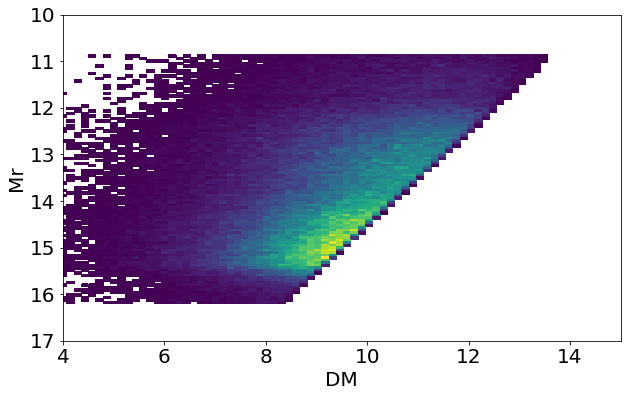

In [52]:
plt.hist2d(ps_gold.loc[disk_mask, 'DM'], ps_gold.loc[disk_mask, 'Phot_Mr'], bins=100, cmin=1)
plt.xlim([4, 15])
plt.ylim([10, 17])
plt.gca().invert_yaxis()
plt.xlabel('DM')
plt.ylabel('Mr')
plt.show()

### Halo

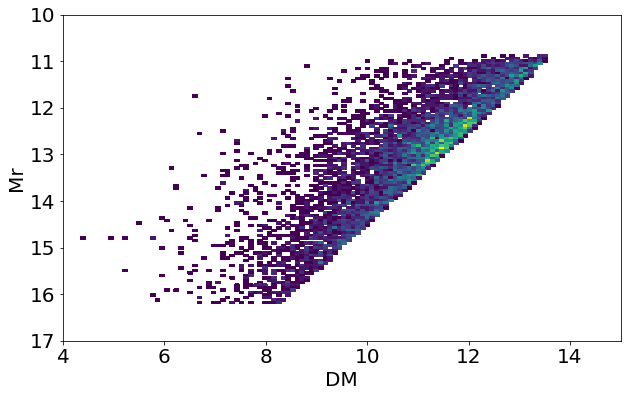

In [53]:
plt.hist2d(ps_gold.loc[halo_mask, 'DM'], ps_gold.loc[halo_mask, 'Phot_Mr'], bins=100, cmin=1)
plt.xlabel('DM')
plt.ylabel('Mr')
plt.xlim([4, 15])
plt.ylim([10, 17])
plt.gca().invert_yaxis()
plt.show()

## Uncorrected distribution of absolute magnitudes

In [54]:
len(ps_gold)

175038

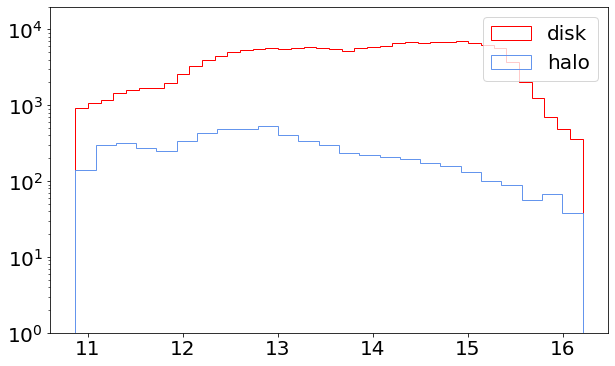

In [55]:
plt.hist(x=ps_gold.loc[disk_mask, 'Phot_Mr'], bins=40, color='r', histtype='step', label = 'disk')
plt.hist(x=ps_gold.loc[halo_mask, 'Phot_Mr'], bins=25, color='cornflowerblue', histtype='step', label = 'halo')
plt.yscale('log') 
plt.ylim([1, 20000])
plt.legend()
plt.show()

## Use Cminus method to recover true distributions of DM and Mr
We assume that DM is independent of Mr

Using the C method implemented in astroML2, compute the differential luminosity function for each subsample (this is the hardest part of this project!). Explain how did you get the normalization constant. 

In [56]:
from astroML.lumfunc import bootstrap_Cminus

In [57]:
r_lim = 24.5

# aux arrays
x_fit = np.linspace(0, 15, 42)
y_fit = np.linspace(10, 17, 42)

In [58]:
# Get midpoint of each bin
x_centers_DM = (x_fit[:-1] + x_fit[1:]) / 2 
y_centers = (y_fit[:-1] + y_fit[1:]) / 2 

# get bin widths
x_bin_width = x_fit[1] - x_fit[0]
y_bin_width = y_fit[1] - y_fit[0]

### Try reading in results from saved files

In [59]:
def save_cminus(xdistr, xerr, ydistr, yerr, xfit, yfit, fname, prefix=''):
    nan_arr = np.array([np.nan])
    save = pd.DataFrame({
        f'x{prefix}_distr': np.concatenate([nan_arr, xdistr]), 
        f'x{prefix}_err': np.concatenate([nan_arr, xerr]),
        f'y{prefix}_distr': np.concatenate([nan_arr, ydistr]),
        f'y{prefix}_err': np.concatenate([nan_arr, yerr]),
        'x_fit': xfit, 
        'y_fit': yfit
    })
    save.to_csv(fname, index=False)
    
def save_cminus_output(xdistr, xerr, ydistr, yerr, fname, prefix=''):
    nan_arr = np.array([np.nan])
    save = pd.DataFrame({
        f'x{prefix}_distr': xdistr, 
        f'x{prefix}_err': xerr,
        f'y{prefix}_distr': ydistr,
        f'y{prefix}_err': yerr,
    })
    save.to_csv(fname, index=False)
    
def read_cminus(fname):
    cminus_results = pd.read_csv(fname)
    return list(cminus_results[col].dropna().values for col in cminus_results.columns)

def read_cminus_output(fname):
    cminus_results = pd.read_csv(fname)
    return list(cminus_results[col].values for col in cminus_results.columns)

In [60]:
halo_fname = '../halo_output.csv'
disk_fname = '../disk_output.csv'

halo_save_exists = os.path.exists(halo_fname)
disk_save_exists = os.path.exists(disk_fname)

if halo_save_exists:
    xH_distr, xH_err, yH_distr, yH_err = read_cminus_output(halo_fname)
    
if disk_save_exists:
    xD_distr, xD_err, yD_distr, yD_err = read_cminus_output(disk_fname)



## Run Cminus if no save files exist
### For halo cut

In [61]:
halo_data = ps_gold.loc[halo_mask, ['DM', 'Phot_Mr']].copy()
halo_data['max_DM'] = r_lim - halo_data['Phot_Mr']
halo_data['max_Mr'] = r_lim - halo_data['DM']

halo_x = halo_data['DM']
halo_y = halo_data['Phot_Mr']
halo_xmax = halo_data['max_DM']
halo_ymax = halo_data['max_Mr']
    
if not halo_save_exists:
    xH_distr, xH_err, yH_distr, yH_err = bootstrap_Cminus(halo_x, halo_y, halo_xmax, halo_ymax, x_fit, y_fit, Nbootstraps=20, normalize=True)
    save_cminus(xH_distr, xH_err, yH_distr, yH_err, halo_fname, prefix='H')

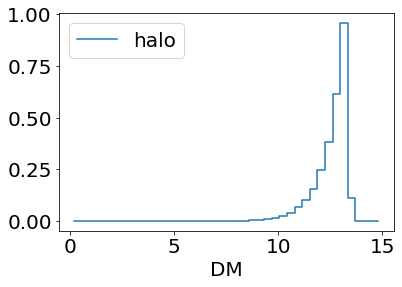

In [62]:
# Check x distr

plt.figure(figsize=(6,4))
plt.step(x_centers_DM, xH_distr, label='halo')
plt.legend()
plt.xlabel('DM')
plt.show()

In [63]:
# Spot check halo data
halo_data[['Phot_Mr', 'DM', 'max_DM', 'max_Mr']].head()

,Phot_Mr,DM,max_DM,max_Mr
363,14.948522,9.178478,9.551478,15.321522
823,11.432426,12.548574,13.067574,11.951426
15422,11.690151,11.161849,12.809849,13.338151
23739,11.895304,12.529696,12.604696,11.970304
36651,12.093449,12.358551,12.406551,12.141449


### For disk cut

In [64]:
disk_data = ps_gold.loc[disk_mask, ['DM', 'Phot_Mr']].copy()
disk_data['max_DM'] = r_lim - disk_data['Phot_Mr']
disk_data['max_Mr'] = r_lim - disk_data['DM']

disk_x = disk_data['DM']
disk_y = disk_data['Phot_Mr']
disk_xmax = disk_data['max_DM']
disk_ymax = disk_data['max_Mr']

if not disk_save_exists:
    xD_distr, xD_err, yD_distr, yD_err = bootstrap_Cminus_fixed(disk_x, disk_y, disk_xmax, disk_ymax, x_fit, y_fit, Nbootstraps=20, normalize=True)
    save_cminus(xD_distr, xD_err, yD_distr, yD_err, disk_fname, prefix='D')

In [65]:
# Spot check disk data
disk_data[['Phot_Mr', 'DM', 'max_DM', 'max_Mr']].head()

,Phot_Mr,DM,max_DM,max_Mr
0,11.335388,11.236612,13.164612,13.263388
3,12.985650,9.849350,11.514350,14.650650
4,13.196236,9.766764,11.303764,14.733236
5,13.323885,10.275115,11.176115,14.224885
11,13.940513,10.423487,10.559487,14.076513


## Plot unnormalized Mr distribution

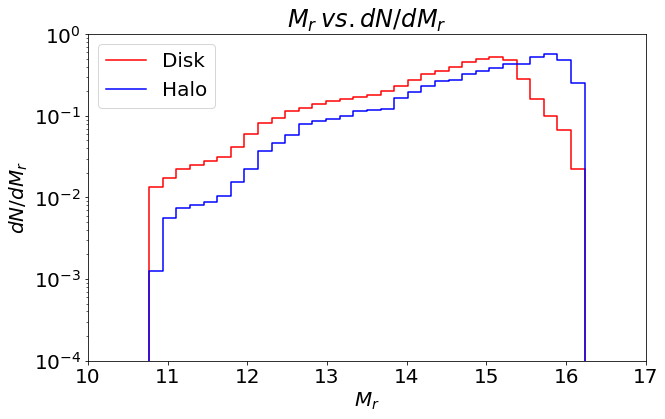

In [66]:
plt.step(y_centers, yD_distr, label='Disk', color='r')
plt.step(y_centers, yH_distr, label='Halo', color='b')
plt.yscale('log')
plt.xlim([10, 17])
plt.ylim([0.0001, 1])
plt.title(r'$M_r\:vs. dN/dM_r$')
plt.xlabel(r'$M_r$')
plt.ylabel(r'$ dN/dM_r$')
plt.legend()
plt.show()

### Normalization coefficients (account for flux selection effects)

In [67]:
# Set bounds for normalization
DM_max = 11
Mr_max = r_lim - DM_max

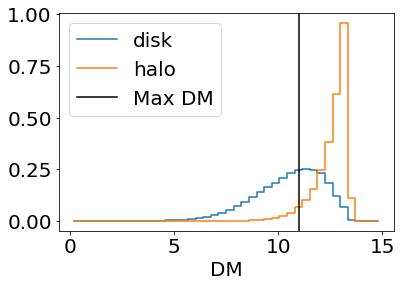

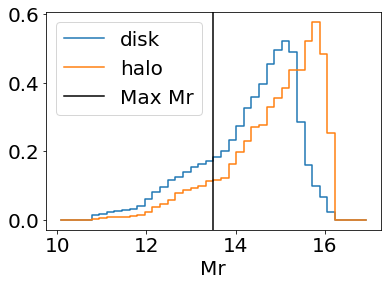

In [68]:
# Plot distributions from Cminus along with bounds for normalization

plt.figure(figsize=(6,4))
plt.step(x_centers_DM, xD_distr, label='disk')
plt.step(x_centers_DM, xH_distr, label='halo')
plt.axvline(DM_max, color='k', label='Max DM')
plt.legend()
plt.xlabel('DM')
plt.show()
plt.figure(figsize=(6,4))

plt.step(y_centers, yD_distr, label='disk')
plt.step(y_centers, yH_distr, label='halo')
plt.axvline(Mr_max, color='k', label='Max Mr')
plt.legend()
plt.xlabel('Mr')
plt.show()


### Find constant C for disk and halo
C represents the true number of stars in the disk and halo, if we weren't flux limited. We obtain this value by finding the probability $P(DM < DM_{max}, M_r < M_{r, max})$ for $DM_{max}$ and $M_{r, max}$ that are not flux limited. We chose $DM_{max} = 11$ and $M_{r,max} = r_{lim} - DM_{max}$. By counting the number of WDs inn our data sample, and then dividing by this probability (i.e. the probability that we would find a WD with $DM < DM_{max}, M_r < M_{r, max}$), we get the expected number of WDs total.

We repeat this procedure for both disk and halo data/distributions.

\begin{equation}
P(DM < DM_{max}, M_r < M_{r, max}) = P(DM < DM_{max}) \times P(M_r < M_{r, max}) \\
                                     = \int_{0}^{DM_{max}} xOutput\,d(DM) * \int_{0}^{M_{r,max}} yOutput \,dM_r
\end{equation}
Where xOutput and yOutput are the PDFs from running Cminus

In [70]:
# Integrate pdf up to DM_max
xH_areas = xH_distr * x_bin_width
cumlDM_H = sum(xH_areas[x_centers_DM <= DM_max])

# Integrate pdf up to Mr_max
yH_areas = yH_distr * y_bin_width
cumlMr_H = sum(yH_areas[y_centers <= Mr_max])

# Number of halo stars < (DM_max, Mr_max)
Nhalo = len(halo_data.query(f'DM <= {DM_max} & Phot_Mr <= {Mr_max}'))

# Total number of halo stars
C_H = Nhalo / (cumlDM_H * cumlMr_H) # total number of halo WDs in b > 60 sample 

In [71]:
# Integrate pdf up to DM_max
xD_areas = xD_distr * x_bin_width
cumlDM_D = sum(xD_areas[x_centers_DM < DM_max])

# Integrate pdf up to Mr_max
yD_areas = yD_distr * y_bin_width
cumlMr_D = sum(yD_areas[y_centers < Mr_max])

# Number of disk stars < (DM_max, Mr_max)
Ndisk = len(disk_data.query(f'DM <= {DM_max} & Phot_Mr <= {Mr_max}'))

# Total number of disk stars
C_D = Ndisk / (cumlDM_D * cumlMr_D) # total number of disk WDs in b > 60 sample

In [72]:
# Total WDs in the area surveyed if we weren't flux limited:
print(C_D, C_H)

516739.71604251664 313670.8317504359


## Plot densities as a function of distance (Part E)

Explanation for how to get disk densities from C and x distrbution (halo densities can be calculated similarly):
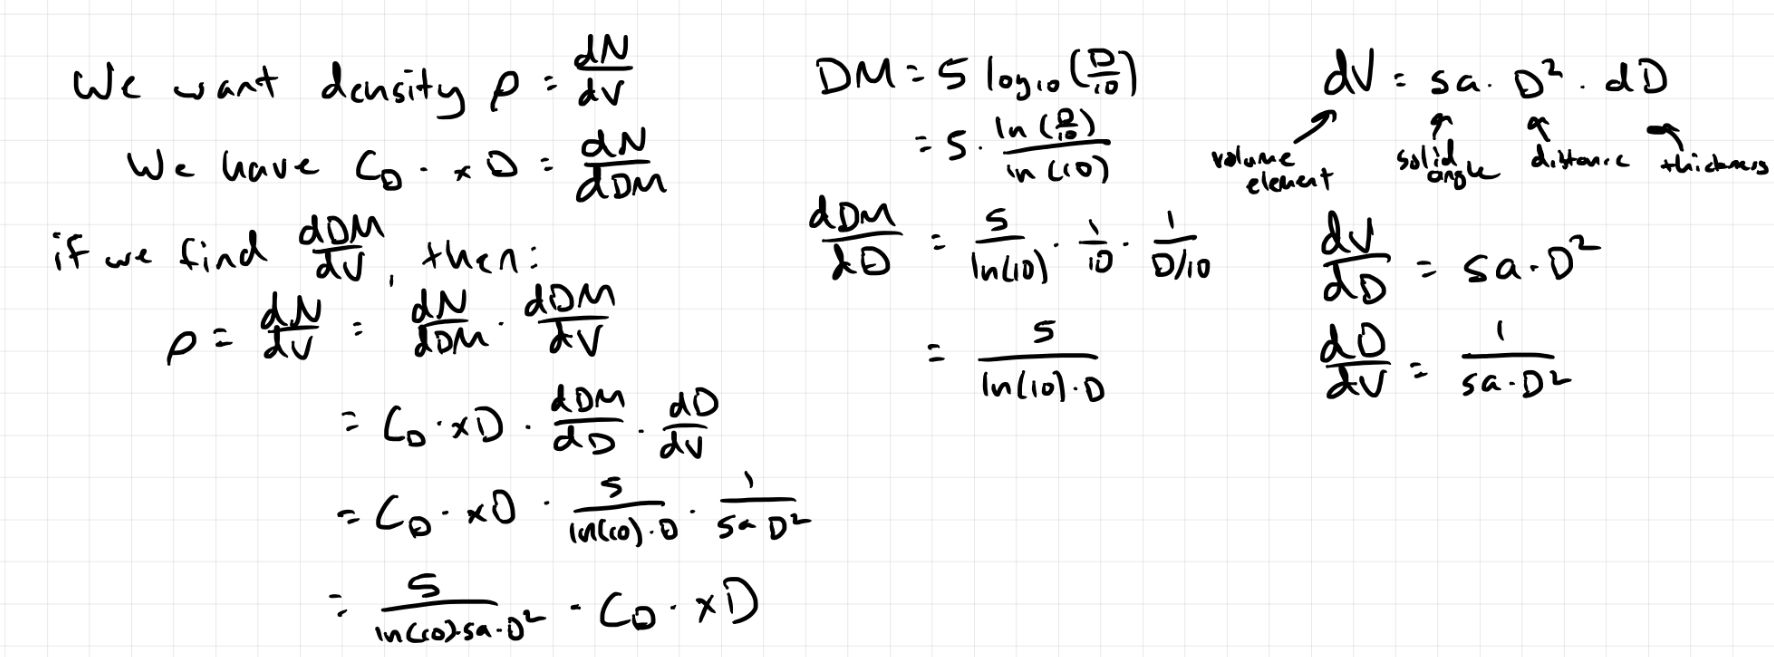

In [73]:
def dm_to_D(dm):
    return 10 ** ((dm / 5) + 1)

def get_dm_dV(distances, sa):
    return 5 / np.log(10) / distances ** 3 / sa

x_centers = dm_to_D(x_centers_DM)
dDM_over_dV = get_dm_dV(x_centers, .8418)

rhoD = C_D * xD_distr * dDM_over_dV
rhoH = C_H * xH_distr * dDM_over_dV

errorD = C_D * xD_err * dDM_over_dV
errorH = C_H * xH_err * dDM_over_dV

### Get density at D=0
This is one component of the luminosity function $\Phi(M_r|D=0)=\Psi(M_r)*\rho(D=0)$ since we assumed the two components are independent


In [74]:
def exp(x, A, k):
    return A * np.exp(-k * x)

exp_fit_mask = (x_centers > 100) | (x_centers < 500)
popt, _ = curve_fit(exp, x_centers[exp_fit_mask], rhoD[exp_fit_mask])
rhoD0 = popt[0]

rhoH0 = np.median(rhoH[x_centers > 500])

In [75]:
# densities at 0 pc
print(rhoD0, rhoH0)

0.004919051799490111 9.557384390898553e-06


In [76]:
disk_truth = pd.read_csv('../WDlumfuncDisk.dat', delim_whitespace=True, comment='#', names=['Mr', 'Phi'])
halo_truth = pd.read_csv('../WDlumfuncHalo.dat', delim_whitespace=True, comment='#', names=['Mr', 'Phi'])

halo_truth['Phi'] = halo_truth['Phi'] / 200  # Fix bug

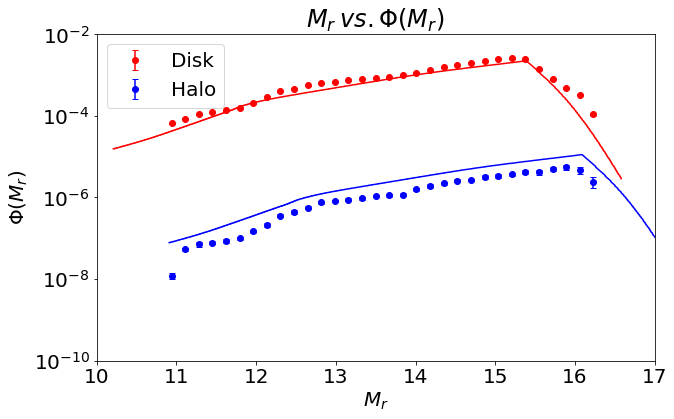

In [77]:
plt.errorbar(y_centers, yD_distr*rhoD0, yD_err*rhoD0, fmt='o', capsize=3, label='Disk', color='r')
plt.errorbar(y_centers, yH_distr*rhoH0, yH_err*rhoH0, fmt='o', capsize=3, label='Halo', color='b')
plt.plot(disk_truth['Mr'], disk_truth['Phi'], color='r')
plt.plot(halo_truth['Mr'], halo_truth['Phi'], color='b')

plt.yscale('log')
plt.xlim([10, 17])
plt.ylim([1e-10, .01])
plt.title(r'$M_r\:vs. \Phi(M_r)$')
plt.xlabel(r'$M_r$')
plt.ylabel(r'$\Phi(M_r)$')
plt.legend()

# Part E

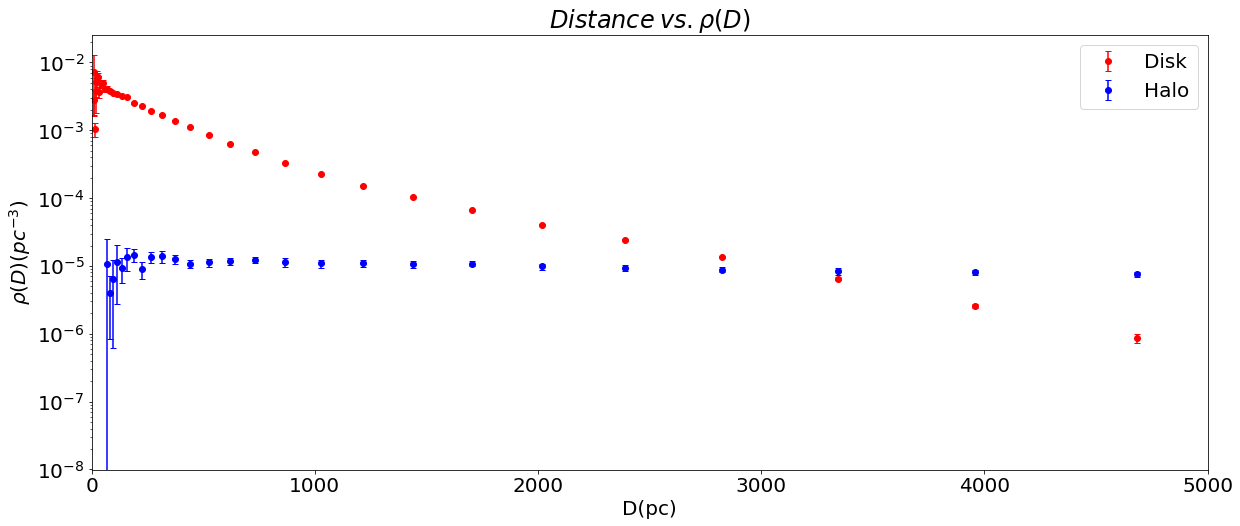

In [77]:
plt.figure(figsize=(20, 8))
plt.errorbar(x_centers, rhoD, errorD, fmt='o', capsize=3, color='r', label='Disk')
plt.plot
plt.errorbar(x_centers, rhoH, errorH, fmt='o', capsize=3, color='b', label='Halo')
plt.yscale('log')
plt.xlim([0, 5000])
plt.xlabel('D(pc)')
plt.ylabel(r'$\rho(D)(pc^{-3})$')
plt.title(r'$Distance\: vs. \rho(D)$')
plt.legend()
# plt.ylim([0.01, 1000])
plt.show()

The disk densities are in line with what we expect: roughly an exponential decrease, as seen by a linear-ish decrease in the semi-log plot above. Furthermore the intersection around 3kpc matches the literature (e.g. Ivezic 2008) for where the density of stars transitions from being dominated by disk objects to halo objects. We note the fairly constant density for halo stars, at least out to 5 kpc--even though we might expect in the long run that density is propotional to $1/D^3$.

Pasted below are the log stellar densities for disk and halo stars from HW1, where we split our disk abnd halo segments at metalicity greater than or less than -1, respectively
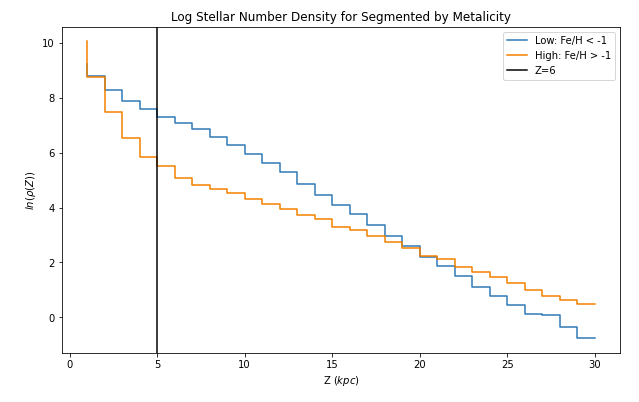
Even though we are not flux limited in this plot until after Z=5kpc, we can see a small, although steady drop in halo stellar density between Z=0 and Z=5, which is not present in the white dwarf densities. 

We expect that in HW3, our disk halo split is much more precise, due to our use of velocity to make the distinction, and this is supported by the very low contamination values that we find. Contamination was a huge problem in interpreting our densities from HW1--past 10 parsecs or so, we became dominated in that dataset by disk stars misclassified as halo stars. 

Note that in these comparisons, we are implicitly assuming that the density of white dwarfs is directly proportional to the stellar density.

# Run Cminus using truth halo and disk split

In [87]:
disk_mask_truth = ps_mask and (truth['P'] == 1)
halo_mask_truth = ps_mask and (truth['P'] == 2)

In [88]:
halo_data_truth = ps_gold.loc[halo_mask_truth, ['DM', 'Phot_Mr']].copy()
halo_data_truth['max_DM'] = r_lim - halo_data_truth['Phot_Mr']
halo_data_truth['max_Mr'] = r_lim - halo_data_truth['DM']

halo_x_truth = halo_data_truth['DM']
halo_y_truth = halo_data_truth['Phot_Mr']
halo_xmax_truth = halo_data_truth['max_DM']
halo_ymax_truth = halo_data_truth['max_Mr']

xH_distr_truth, xH_err_truth, yH_distr_truth, yH_err_truth = bootstrap_Cminus(halo_x_truth, halo_y_truth, halo_xmax_truth, halo_ymax_truth, x_fit, y_fit, Nbootstraps=20, normalize=True)


In [89]:
disk_data_truth = ps_gold.loc[disk_mask_truth, ['DM', 'Phot_Mr']].copy()
disk_data_truth['max_DM'] = r_lim - disk_data_truth['Phot_Mr']
disk_data_truth['max_Mr'] = r_lim - disk_data_truth['DM']

disk_x_truth = disk_data_truth['DM']
disk_y_truth = disk_data_truth['Phot_Mr']
disk_xmax_truth = disk_data_truth['max_DM']
disk_ymax_truth = disk_data_truth['max_Mr']

xD_distr_truth, xD_err_truth, yD_distr_truth, yD_err_truth = bootstrap_Cminus(disk_x_truth, disk_y_truth, disk_xmax_truth, disk_ymax_truth, x_fit, y_fit, Nbootstraps=20, normalize=True)

In [90]:
# Set bounds for normalization
DM_max = 11.5
Mr_max = r_lim - DM_max

In [91]:
# Integrate pdf up to DM_max
xH_areas_truth = xH_distr_truth * x_bin_width
cumlDM_H_truth = sum(xH_areas_truth[x_centers_DM <= DM_max])

# Integrate pdf up to Mr_max
yH_areas_truth = yH_distr_truth * y_bin_width
cumlMr_H_truth = sum(yH_areas_truth[y_centers <= Mr_max])

# Number of halo stars < (DM_max, Mr_max)
Nhalo_truth = len(halo_data_truth.query(f'DM <= {DM_max} & Phot_Mr <= {Mr_max}'))

# Total number of halo stars
C_H_truth = Nhalo_truth / (cumlDM_H_truth * cumlMr_H_truth) # total number of halo WDs in b > 60 sample 

In [92]:
# Integrate pdf up to DM_max
xD_areas_truth = xD_distr_truth * x_bin_width
cumlDM_D_truth = sum(xD_areas_truth[x_centers_DM <= DM_max])

# Integrate pdf up to Mr_max
yD_areas_truth = yD_distr_truth * y_bin_width
cumlMr_D_truth = sum(yD_areas_truth[y_centers <= Mr_max])

# Number of halo stars < (DM_max, Mr_max)
Ndisk_truth = len(disk_data_truth.query(f'DM <= {DM_max} & Phot_Mr <= {Mr_max}'))

# Total number of halo stars
C_D_truth = Ndisk_truth / (cumlDM_D_truth * cumlMr_D_truth) # total number of halo WDs in b > 60 sample 

In [93]:
print(C_H_truth, C_D_truth)

490271.59299111034 464501.3175408297


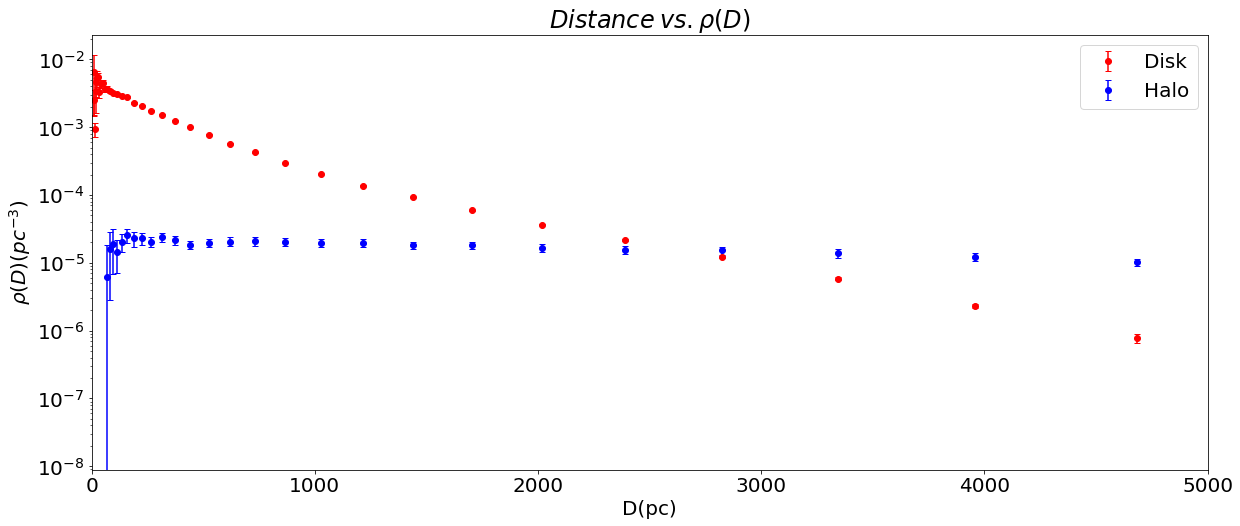

In [94]:
x_centers = dm_to_D(x_centers_DM)
dDM_over_dV = get_dm_dV(x_centers, .8418)

rhoD_truth = C_D_truth * xD_distr_truth * dDM_over_dV
rhoH_truth = C_H_truth * xH_distr_truth * dDM_over_dV

errorD_truth = C_D_truth * xD_err_truth * dDM_over_dV
errorH_truth = C_H_truth * xH_err_truth * dDM_over_dV



plt.figure(figsize=(20, 8))
plt.errorbar(x_centers, rhoD_truth, errorD_truth, fmt='o', capsize=3, color='r', label='Disk')

plt.errorbar(x_centers, rhoH_truth, errorH_truth, fmt='o', capsize=3, color='b', label='Halo')
plt.yscale('log')
plt.xlim([0, 5000])
plt.xlabel('D(pc)')
plt.ylabel(r'$\rho(D)(pc^{-3})$')
plt.title(r'$Distance\: vs. \rho(D)$')
plt.legend()
# plt.ylim([0.01, 1000])
plt.show()

In [95]:
popt, _ = curve_fit(exp, x_centers[exp_fit_mask], rhoD_truth[exp_fit_mask])
rhoD0_truth = popt[0]

rhoH0_truth = np.median(rhoH_truth[(x_centers > 500)])

In [96]:
popt

array([0.00442177, 0.00319329])

In [97]:
print(rhoD0_truth, rhoH0_truth)

0.00442176905936216 1.6174062112433216e-05


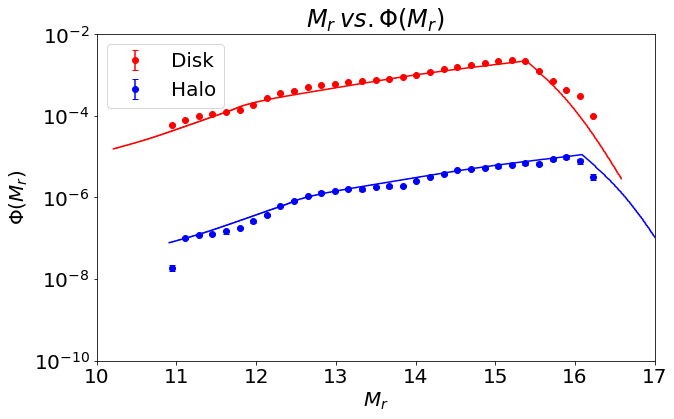

In [98]:
plt.errorbar(y_centers, yD_distr_truth*rhoD0_truth, yD_err_truth*rhoD0_truth, fmt='o', capsize=3, label='Disk', color='r')
plt.errorbar(y_centers, yH_distr_truth*rhoH0_truth, yH_err_truth*rhoH0_truth, fmt='o', capsize=3, label='Halo', color='b')
plt.plot(disk_truth['Mr'], disk_truth['Phi'], color='r')
plt.plot(halo_truth['Mr'], halo_truth['Phi'], color='b')

plt.yscale('log')
plt.xlim([10, 17])
plt.ylim([1e-10, .01])
plt.title(r'$M_r\:vs. \Phi(M_r)$')
plt.xlabel(r'$M_r$')
plt.ylabel(r'$\Phi(M_r)$')
plt.legend()

# Old work

# debugging weird behavior

In [371]:
halo_objects = pd.read_csv('../debugging.csv', delim_whitespace=True)

In [372]:
halo_objects
halo_objects.columns = ['DM', 'M_r', 'max_DM', 'max_Mr']
halo_objects.columns = ['DM', 'max_DM', 'M_r', 'max_Mr']
halo_objects = halo_objects[['DM', 'M_r', 'max_DM', 'max_Mr']]

In [368]:
share_cols = [x for x in halo_objects.index if x in halo_data.index]

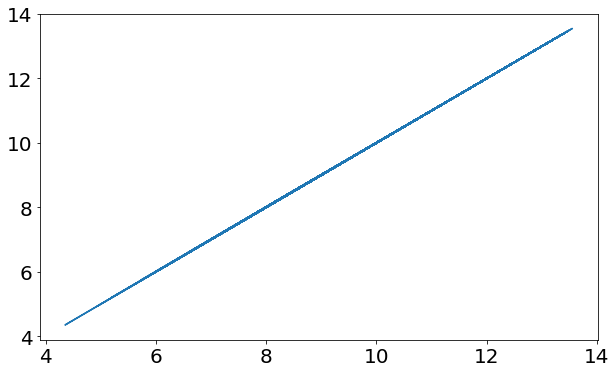

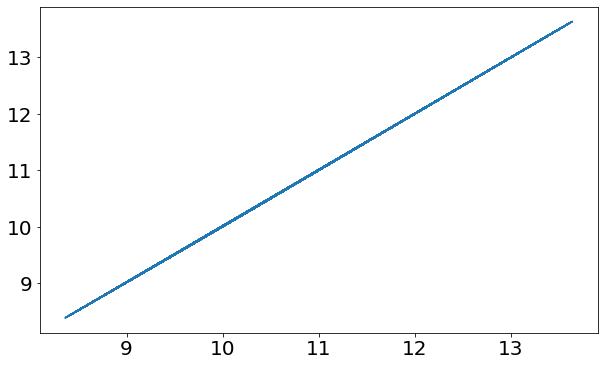

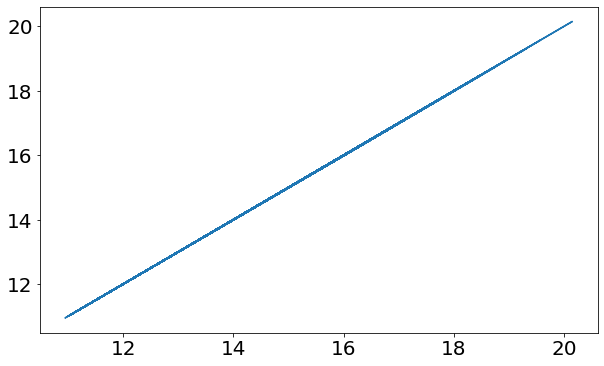

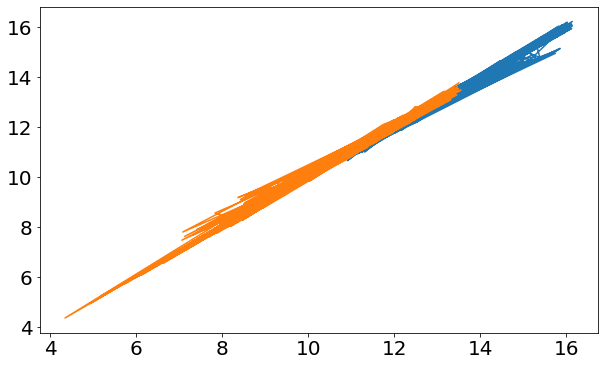

In [263]:
for col in ['DM', 'max_DM', 'max_Mr']:
    plt.plot(halo_objects.loc[share_cols,col], halo_data.loc[share_cols, col])
    plt.show()
plt.plot(halo_objects.loc[share_cols,'M_r'], truth.loc[share_cols, 'Mr'])
plt.plot(halo_objects.loc[share_cols,'DM'], truth.loc[share_cols, 'DM'])

In [298]:
sam_only_rows = list(halo_objects[~halo_objects.index.isin(share_cols)].index)

In [309]:
halo_objects.drop(216660, inplace=True)

In [321]:
halo_objects[~halo_objects.index.isin([216660])]

,DM,M_r,max_DM,max_Mr
363,9.174685,14.952315,9.547685,15.325315
823,12.547563,11.433437,13.066563,11.952437
15422,11.160072,11.691928,12.808072,13.339928
23739,12.527618,11.897382,12.602618,11.972382
36651,12.356402,12.095598,12.404402,12.143598
...,...,...,...,...
905491,11.329291,12.373709,12.126291,13.170709
905563,7.278719,14.099281,10.400719,17.221281
905617,12.587371,11.075629,13.424371,11.912629
905808,9.256929,14.600071,9.899929,15.243071


In [369]:
halo_data[~halo_data.index.isin(share_cols)]

,DM,Phot_Mr,max_DM,max_Mr
636480,11.450327,12.561673,11.938327,13.049673
685189,11.941850,12.523150,11.976850,12.558150
870124,12.018114,12.155886,12.344114,12.481886


In [315]:
sam_only_rows = [144296, 216660, 263028, 389058, 396681, 402531, 499324]

In [305]:
sam_only_rows[-5:]

[263028, 389058, 396681, 402531, 499324]

In [380]:
halo_x = halo_objects['DM']
halo_y = halo_objects['M_r']
halo_xmax = halo_objects['max_DM']
halo_ymax = halo_objects['max_Mr']

xH, dxH, dyH, yH = bootstrap_Cminus(halo_x, halo_y, halo_xmax, halo_ymax, x_fit, y_fit, Nbootstraps=1, normalize=True)


In [382]:
yH

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

## Bug in Cminus?!?!?

In [384]:
from astroML.lumfunc import Cminus

In [479]:
# Set state of random generator if trying to reproduce. Skip this cell if first time.
np.random.set_state(test_state)

In [478]:
# Save state of the random seed before each run
test_state = np.random.get_state()

### run the following cell until we get a sample that breaks cminus

In [562]:
ind = np.random.randint(0, len(halo_x), len(halo_x))
test_x = halo_x.reset_index(drop=True)[ind]
test_y = halo_y.reset_index(drop=True)[ind]
test_xmax = halo_xmax.reset_index(drop=True)[ind]
test_ymax = halo_ymax.reset_index(drop=True)[ind]
xH, yH, cuml_xH, cuml_yH = Cminus(test_x, test_y, test_xmax, test_ymax)


> <ipython-input-559-fe795b7fa7ce>(43)testCminus()
     41     Ny[0] = np.inf
     42     pdb.set_trace()
---> 43     cuml_y = np.cumprod(1. + 1. / Ny)
     44     Ny[0] = 0
     45 

ipdb> c


In [ ]:
# save example that seems to break Cminus
pd.DataFrame({'xH':test_x, 'yH':test_y, 'xmaxH':test_xmax, 'ymaxH':test_ymax}).to_csv('../break_cminus.csv', index=False)

### use pdb to examine internal variables of Cminus

In [ ]:
test_data = pd.read_csv('../break_cminus.csv.gz')
x = test_data['xH']
y = test_data['yH']
xmax = test_data['xmaxH']
ymax = test_data['ymaxH']

xH, yH, cuml_xH, cuml_yH = testCminus(x, y, xmax, ymax)
print(cuml_yH) # nans

## Toy example

In [542]:
x1, y1, xmax1, ymax1 =map(np.array, ( [10.02, 10.00], [14.97, 14.99], [10.03, 10.01], [14.98, 15.00]))

In [543]:
Cminus(x1, y1, xmax1, ymax1)

(array([0., 0.]), array([0., 0.]), array([ 0., nan]), array([ 0., nan]))

### check that all constraints hold

In [544]:
x1 + ymax1

array([25., 25.])

In [545]:
y1 + xmax1

array([25., 25.])

In [546]:
x1 < xmax1

array([ True,  True])

In [547]:
y1 < ymax1

array([ True,  True])

### add python debugger to Cminus to examine variables while running 

In [559]:
import pdb
def testCminus(x, y, xmax, ymax):
    """Lynden-Bell's C-minus method

    Parameters
    ----------
    x : array_like
        array of x values
    y : array_like
        array of y values
    xmax : array_like
        array of maximum x values for each y value
    ymax : array_like
        array of maximum y values for each x value

    Returns
    -------
    Nx, Ny, cuml_x, cuml_y: ndarrays
        Nx and cuml_x are in the order of the sorted x array
        Ny and cuml_y are in the order of the sorted y array
    """
    # make copies of input
    x, y, xmax, ymax = map(np.array, (x, y, xmax, ymax))

    Nall = len(x)

    cuml_x = np.zeros(x.shape)
    cuml_y = np.zeros(y.shape)
    Nx = np.zeros(x.shape)
    Ny = np.zeros(y.shape)

    # first the y direction.
    i_sort = np.argsort(y)
    x = x[i_sort]
    y = y[i_sort]
    xmax = xmax[i_sort]
    ymax = ymax[i_sort]

    for j in range(1, Nall):
        Ny[j] = np.sum(x[:j] < xmax[j])
    Ny[0] = np.inf
    pdb.set_trace()
    cuml_y = np.cumprod(1. + 1. / Ny)
    Ny[0] = 0

    # renormalize
    cuml_y *= Nall / cuml_y[-1]

    #now the x direction
    i_sort = np.argsort(x)
    x = x[i_sort]
    y = y[i_sort]
    xmax = xmax[i_sort]
    ymax = ymax[i_sort]

    for i in range(1, Nall):
        Nx[i] = np.sum(y[:i] < ymax[i])
    Nx[0] = np.inf
    cuml_x = np.cumprod(1. + 1. / Nx)
    Nx[0] = 0

    # renormalize
    cuml_x *= Nall / cuml_x[-1]

    return Nx, Ny, cuml_x, cuml_y

In [271]:
ps_gold.columns

Index(['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs',
       'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs',
       'muDecObs', 'muErr', 'SNR', 'mu', 'g-r', 'Phot_Mr', 'D(pc)'],
      dtype='object')

In [61]:


disk_data = ps_gold.loc[disk_mask, ['DM', 'Phot_Mr']].copy()
disk_data['max_DM'] = r_lim - disk_data['Phot_Mr']
disk_data['max_Mr'] = r_lim - disk_data['DM']

disk_x = disk_data['D(pc)']
disk_y = disk_data['Phot_Mr']
disk_xmax = disk_data['max_DM']
disk_ymax = disk_data['max_Phot_Mr']

xD_distr, xD_err, yD_distr, yD_err = bootstrap_Cminus(disk_x, disk_y, disk_xmax, disk_ymax, x_fit, y_fit, Nbootstraps=20, normalize=True)



halo_data = ps_gold.loc[halo_mask, ['DM', 'Phot_Mr']].copy()
halo_data['max_DM'] = r_lim - halo_data['Phot_Mr']
halo_data['max_Mr'] = r_lim - halo_data['DM']

halo_x = halo_data['D(pc)']
halo_y = halo_data['Phot_Mr']
halo_xmax = halo_data['max_DM']
halo_ymax = halo_data['max_Phot_Mr']

xH_distr, xH_err, yH_distr, yH_err = bootstrap_Cminus(halo_x, halo_y, halo_xmax, halo_ymax, x_fit, y_fit, Nbootstraps=20, normalize=True)

# disk_Nx, disk_Ny, disk_cuml_x, disk_cuml_y = Cminus(disk_x, disk_y, disk_xmax, disk_ymax)

halo = ps_gold.loc[halo_mask, ['D(pc)', 'Phot_Mr']].round({'D(pc)':-2, 'Phot_Mr':1})
halo_max_D = halo.groupby('Phot_Mr')['D(pc)'].apply(max)
halo_max_Mr = halo.groupby('D(pc)')['Phot_Mr'].apply(max)

halo_max_D.name = 'max D(pc)'
halo_max_Mr.name = 'max Phot_Mr'

halo_data = halo.merge(halo_max_D, left_on='Phot_Mr', right_index=True).merge(halo_max_Mr, left_on='D(pc)', right_index=True)

halo_x = halo_data['D(pc)']
halo_y = halo_data['Phot_Mr']
halo_xmax = halo_data['max_DM']
halo_ymax = halo_data['max_Mr']

halo_Nx, halo_Ny, halo_cuml_x, halo_cuml_y = Cminus(halo_x, halo_y, halo_xmax, halo_ymax)

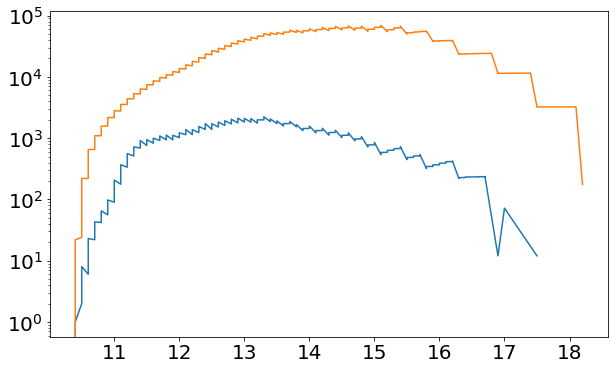

In [63]:
plt.semilogy(halo_y.sort_values(), halo_Ny)
plt.semilogy(disk_y.sort_values(), disk_Ny)

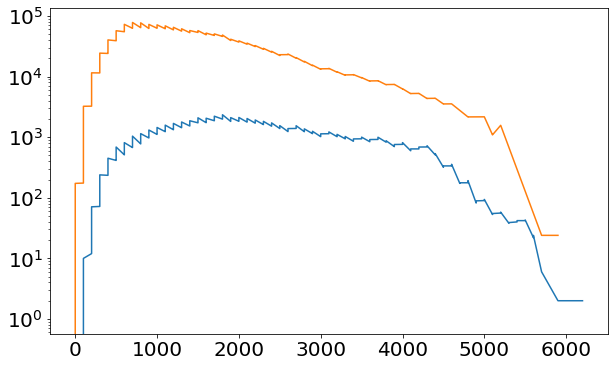

In [64]:
plt.semilogy(halo_x.sort_values(), halo_Nx)
plt.semilogy(disk_x.sort_values(), disk_Nx)

Plot your results in a log(Φ) vs. Mr diagram (with error bars!), and overplot the true luminosity function listed in files WDlumfuncDisk.dat and WDlumfuncHalo.dat (the differential LF listed in the second column is expressed as the number of stars per pc3 and mag; the LFs are slightly inconsistent with the Harris et al. due to a bug in simulations but, importantly, they do correspond to the “true” LFs for the simulated sample). 

Comment on (dis)agreement between your Φ and the true Φ (which was used to generate the simulated sample). IMPORTANT - YOU NEED TO FIX A BUG: Divide the halo Φ from file WDlumfuncHalo.dat by 200 to get a proper normalization in units of stars per pc3 and mag

In [ ]:
disk = ps_gold.loc[disk_mask, ['D(pc)', 'Phot_Mr']].round({'D(pc)':-2, 'Phot_Mr':1})
disk_max_D = disk.groupby('Phot_Mr')['D(pc)'].apply(max)
disk_max_Mr = disk.groupby('D(pc)')['Phot_Mr'].apply(max)

disk_max_D.name = 'max D(pc)'
disk_max_Mr.name = 'max Phot_Mr'

disk_data = disk.merge(disk_max_D, left_on='Phot_Mr', right_index=True).merge(disk_max_Mr, left_on='D(pc)', right_index=True)

disk_x = disk_data['D(pc)']
disk_y = disk_data['Phot_Mr']
disk_xmax = disk_data['max D(pc)']
disk_ymax = disk_data['max Phot_Mr']

disk_Nx, disk_Ny, disk_cuml_x, disk_cuml_y = Cminus(disk_x, disk_y, disk_xmax, disk_ymax)

halo = ps_gold.loc[halo_mask, ['D(pc)', 'Phot_Mr']].round({'D(pc)':-2, 'Phot_Mr':1})
halo_max_D = halo.groupby('Phot_Mr')['D(pc)'].apply(max)
halo_max_Mr = halo.groupby('D(pc)')['Phot_Mr'].apply(max)

halo_max_D.name = 'max D(pc)'
halo_max_Mr.name = 'max Phot_Mr'

halo_data = halo.merge(halo_max_D, left_on='Phot_Mr', right_index=True).merge(halo_max_Mr, left_on='D(pc)', right_index=True)

halo_x = halo_data['D(pc)']
halo_y = halo_data['Phot_Mr']
halo_xmax = halo_data['max D(pc)']
halo_ymax = halo_data['max Phot_Mr']

halo_Nx, halo_Ny, halo_cuml_x, halo_cuml_y = Cminus(halo_x, halo_y, halo_xmax, halo_ymax)

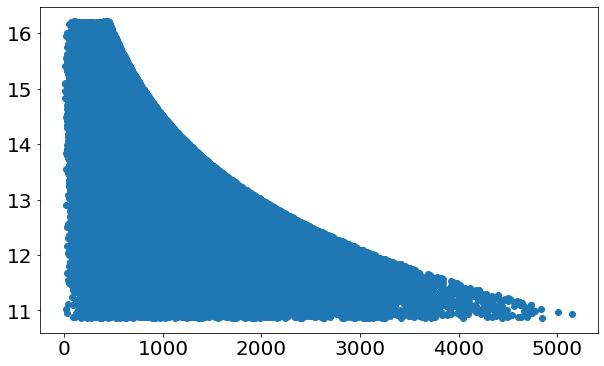

In [64]:
# (x, y) -> (DM, Phot_Mr)
plt.scatter(ps_gold.loc[disk_mask, 'D(pc)'], ps_gold.loc[disk_mask, 'Phot_Mr'])

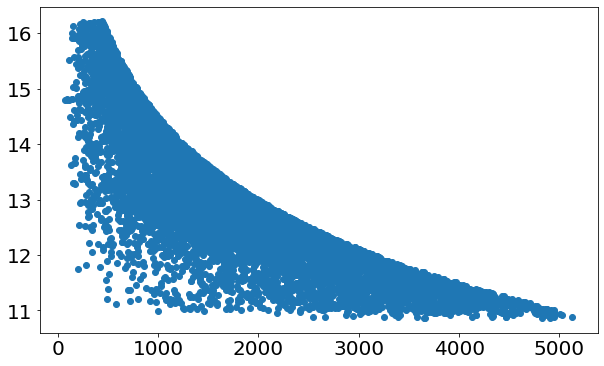

In [59]:
plt.scatter(ps_gold.loc[halo_mask, 'D(pc)'], ps_gold.loc[halo_mask, 'Phot_Mr'])

In [ ]:
def get_Dmax_from_M(r_lim, Mr):
    return 10 ** ((r_lim - Mr) / 5 + 1)

def get_Mmax_from_D(r_lim, D):
    return r_lim - 5 * np.log10(D / 10)

In [ ]:
# Wrote this function after computing the CDF values

def find_cdf(distr, max_value, bins):
    '''
    Find the CDF(max_value) given the distribution from Cminus
    
    distr: output distribution from Cminus (this is the PDF)
    max_value: the cuttoff value in distr (i.e. what to integrate up to)
    bins: the x_fit or y_fit parameter in Cminus, gives the bins of the distribution
    '''
    bin_width = bins[1] - bins[0]  # Get bin width
    mids = (bins[1:] + bins[:-1]) / 2 # get midpoint of each bin
    areas = distr * bin_width   # integrate numerically
    return sum(areas[mids <= max_value])